---
# TOP SOLANA TRADERS : BEHAVIOUR ANALYSIS
---

**Introduction**

In the growing world of digital assets, accurate analysis is key. NFTs on the Solana blockchain are becoming significant players in this space. To dive deeper into these assets, I hereby offer a detailed analysis, building on the work already shown in my dashboard at https://flipsidecrypto.xyz/digital_boy99/top-solana-nft-traders-top-solana-nft-traders-5AgAbK . As such, for more clarity on the SQL queries performed below as well a context (eg : criteria selection for best traders), refer to my dashboard on Flipside.


The analysis is delineated as follows:

**PART 1: Data Collection from Flipside Crypto and Magic Eden API**

In this section, I gather data from the Flipside Crypto dashboard. This data gives an overall view of NFT trades. However, Flipside doesn't specify which collection each NFT belongs to. To get this information, I've used the Magic Eden API. This means for every NFT trade we see on Flipside, we now also know its associated collection from Magic Eden. This combined data will be the base for our further analysis in the upcoming sections.


**PART 2: Pinpointing Key Collections**

This analysis starts by first examining the holding durations of NFTs. To accomplish this, I delve into the trades made by the top Solana NFT traders over the last 30 days (top traders as defined on the Flipside dashboard). This exploration uncovers that the majority of these NFTs are held for a duration of less than 7 days. Given this insight, I decide focus on NFTs that were both acquired and sold by our traders of interest within this 7-day window. This allows us to identify the collections engaged in by these traders, pinpointing those that appear most lucrative.

**PART 3: Data Collection and storage : Target Collections**

After identifying the main collections in Part 1, this section gathers detailed data on these collections preferred by top traders. The goal is straightforward: collect as much data as we can without diving deep into analysis yet.

We start by using the Magic Eden API to get relevant stats. Next, we check listings and track the actions of the top holders in these collections.

**PART 4: Current Trades**

Using our background data, we now look at real-time market actions. We're focused on the buying and selling patterns of our top traders. This gives us a clearer picture of ongoing investment trends, when to buy or sell, and any portfolio change suggestions.

**PART 5:Analyzing today's collection of interest**

Here, we bring together our data to highlight the most traded collections in the past day. We also look at shorter term movements (6h, 1h). The information from the earlier sections, especially Part 2, helps stakeholders make educated buy or sell decisions about these collections. Above that, Twitter data is collected for the collection of interet and sentiment analysis is performed.


Disclaimer: This analysis offers a snapshot of the current market but isn't financial advice. Investors should do their own research and consider seeking professional advice before making financial choices.


NB : to run this script succesfully, one will need a MongoDB URI to store data, Flipside keys to gather data and an apify API token to scrape data from Twitter.

---
# PART 0 : Imports
---

In [91]:
# Importing necessary libraries

import requests
import seaborn as sns
import pandas as pd
import numpy as np
import pymongo
import datetime
import json
import matplotlib.pyplot as plt
import time
import urllib.request


from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

# Flipside imports and keys

from flipside import Flipside

# FLIPSIDE_KEYS = your flipside keys

flipside = Flipside(FLIPSIDE_KEYS, "https://api-v2.flipsidecrypto.xyz")


# MongoDB URL and keys

# MONGO_USER_PASSWORD = your mongodb username and password
MONGO_URI = f"mongodb+srv://{MONGO_USER_PASSWORD}@cluster0.7id2vqq.mongodb.net/?retryWrites=true&w=majority"
client = pymongo.MongoClient(MONGO_URI)
db = client.mydatabase

# Twitter scraper URL and keys

# API_TOKEN = your APify api token 

BASE_URL = 'https://api.apify.com/v2'
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {API_TOKEN}"
}





---

# PART 1: Data Collection from Flipside Crypto and Magic Eden API
       
--- 

In this section, we gather trading data for top NFT traders on Solana across various time frames using queries from Flipside Crypto. To get insight into how these top traders were determined, please refer directly to the Flipside Crypto dashboard.

## 1.1 Definining general querying functions

In [2]:
# Defining general function to query Flipside data 

def run_query_and_get_df(query):
    query_result_set = flipside.query(query)
    columns = query_result_set.columns
    rows = query_result_set.rows
    df = pd.DataFrame(rows, columns=columns)
    df = df.drop('__row_index', axis=1)
    return df

# Adding the collection to the data uing Magic Eden API

def add_collections_to_df(df):
    base_url = "https://api-mainnet.magiceden.dev/v2/tokens/"
    collections = []
    for nft in df['nft']:
        url = f"{base_url}/{nft}"
        headers = {"accept": "application/json"}
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            info = json.loads(response.text)
            collections.append(info.get('collection', None))
        else:
            collections.append(None)
    df['collection'] = collections
    return df

## 1.2 Completed trades (NFT both bought and sold over certain time periods)

In [3]:
# SQL Base Template

trades_query = """WITH Purchases AS ( SELECT MARKETPLACE, BLOCK_TIMESTAMP, PURCHASER, MINT, SALES_AMOUNT FROM solana.core.fact_nft_sales WHERE BLOCK_TIMESTAMP >= CURRENT_DATE - INTERVAL '30 days' AND SUCCEEDED = TRUE ), 
Sales AS ( SELECT MARKETPLACE, BLOCK_TIMESTAMP, PURCHASER, SELLER, MINT, SALES_AMOUNT FROM solana.core.fact_nft_sales WHERE BLOCK_TIMESTAMP >= CURRENT_DATE - INTERVAL '30 days' AND SUCCEEDED = TRUE ), 
TradeProfits AS ( SELECT p.PURCHASER, (s.SALES_AMOUNT - p.SALES_AMOUNT) AS Profit FROM Sales s JOIN Purchases p ON p.MINT = s.MINT AND p.PURCHASER = s.SELLER AND p.BLOCK_TIMESTAMP = ( SELECT MAX(p2.BLOCK_TIMESTAMP) FROM Purchases p2 WHERE p2.MINT = s.MINT AND p2.PURCHASER = s.SELLER AND p2.BLOCK_TIMESTAMP < s.BLOCK_TIMESTAMP) ), 
ProfitableTrades AS ( SELECT PURCHASER, COUNT(*) as ProfitableTradeCount FROM TradeProfits WHERE Profit > 0.1 GROUP BY PURCHASER ), 
TotalTrades AS ( SELECT PURCHASER, COUNT(*) as TotalTradeCount FROM TradeProfits GROUP BY PURCHASER ), 
FilteredTrades AS ( SELECT p.PURCHASER, s.SALES_AMOUNT - p.SALES_AMOUNT AS TradeProfit, p.SALES_AMOUNT AS Investment, (s.SALES_AMOUNT - p.SALES_AMOUNT) / p.SALES_AMOUNT AS ROI FROM Sales s JOIN Purchases p ON p.MINT = s.MINT AND p.PURCHASER = s.SELLER AND p.BLOCK_TIMESTAMP = ( SELECT MAX(p2.BLOCK_TIMESTAMP) FROM Purchases p2 WHERE p2.MINT = s.MINT AND p2.PURCHASER = s.SELLER AND p2.BLOCK_TIMESTAMP < s.BLOCK_TIMESTAMP) WHERE (s.SALES_AMOUNT - p.SALES_AMOUNT) / p.SALES_AMOUNT <= 10 AND (s.SALES_AMOUNT - p.SALES_AMOUNT) / p.SALES_AMOUNT >= -10 ), 
TradeMetrics AS ( SELECT PURCHASER, SUM(TradeProfit) AS TotalProfit, SUM(Investment) AS Investment, SUM(TradeProfit) / SUM(Investment) AS ROI FROM FilteredTrades GROUP BY PURCHASER ), 
top50traders AS ( SELECT t.PURCHASER AS trader, IFNULL(p.ProfitableTradeCount, 0) AS ProfitableTradeCount, t.TotalTradeCount, (IFNULL(p.ProfitableTradeCount, 0) * 100.0 / t.TotalTradeCount) AS PercentageProfitableTrades, tm.TotalProfit, tm.Investment, tm.ROI FROM TotalTrades t LEFT JOIN ProfitableTrades p ON t.PURCHASER = p.PURCHASER JOIN TradeMetrics tm ON t.PURCHASER = tm.PURCHASER WHERE t.TotalTradeCount > 20 AND tm.TotalProfit > 1 AND PERCENTAGEPROFITABLETRADES > 80 AND ROI > 0.2 ORDER BY ROI DESC, PercentageProfitableTrades DESC LIMIT 50 ) SELECT p.PURCHASER AS VENDEUR, s.PURCHASER AS ACHETEUR, p.MINT AS NFT, l.LABEL, p.BLOCK_TIMESTAMP AS DATE_ACHAT, s.BLOCK_TIMESTAMP AS DATE_VENTE, DATEDIFF(MINUTE, p.BLOCK_TIMESTAMP, s.BLOCK_TIMESTAMP) AS HODL_TIME, p.SALES_AMOUNT AS PRIX_ACHAT, s.SALES_AMOUNT AS PRIX_VENTE, (s.SALES_AMOUNT - p.SALES_AMOUNT) AS PROFIT, (s.SALES_AMOUNT - p.SALES_AMOUNT) / p.SALES_AMOUNT AS ROI FROM Sales s JOIN Purchases p ON p.MINT = s.MINT AND p.PURCHASER = s.SELLER AND p.BLOCK_TIMESTAMP = ( SELECT MAX(p2.BLOCK_TIMESTAMP) FROM Purchases p2 WHERE p2.MINT = s.MINT AND p2.PURCHASER = s.SELLER AND p2.BLOCK_TIMESTAMP < s.BLOCK_TIMESTAMP) JOIN Top50Traders t50 ON p.PURCHASER = t50.trader LEFT JOIN solana.core.dim_labels l ON p.MINT = l.address WHERE ((s.SALES_AMOUNT - p.SALES_AMOUNT) / p.SALES_AMOUNT) <= 10 AND ((s.SALES_AMOUNT - p.SALES_AMOUNT) / p.SALES_AMOUNT) >= -10 AND s.BLOCK_TIMESTAMP >= CURRENT_DATE - INTERVAL '{interval}' ORDER BY PROFIT DESC;"""

# Fetch Data for 30-day interval : used to understand holding time behavior

trades_30d_query = trades_query.format(interval='30 days')
trades_30d = run_query_and_get_df(trades_30d_query)

# Fetch Data and Collections for 7-day interval : used to understand currently traded collections
trades_7d_query = trades_query.format(interval='7 days')
trades_7d = run_query_and_get_df(trades_7d_query)
trades_7d = add_collections_to_df(trades_7d)

## 1.3 Best traders (+ Related Twitter account)

In [47]:
users_wallets = {
    "@puffpuffjim": "4qf49iU65pFYWTx3hCA7vikRRv5L3pg6im49yHXjLoQN",
    "@MJDiSantis": "CMaSYTPnfp1fnVekRVG5aDmxv4bwXVDrtJwoEYrd6BGT",
    "@JussCubs": "AiwvWy3JQwN6GnKaLRnLhHwbtGnmj2j413TmJtMqBqeG",
    "@thefixir": "Ak9gDjsbNgimx3UAMHu3bHhq4G8boLocZyhjtL598zaM",
    "@CryptocydMina": "CCWxahZcw47EsH8pavCeNKeGbpGNEs5JEKQ17fjP4ehA",
    "@Kard_Lab": "BiKcVb6t6YDZczYjWLjXKwdgAUecdQrp1EJXAfRmu3VR",
    "@0xGokul_": "B8CXgN3GDut2VhY76zvKQ4HnUFMamLoP9295ea2vvev",
    "@DementedNFT": "HUCVagK86Rtq12uw9b3JqBAv2uRhokh7rhwsMbFjWRr7",
    "@TheVsCrypto": "FyYuwARxPfNQQSUG86JRcYxDQh4YQ2Jk5Nm9gUPpZomn",
    "@FeedBlog": "HUVrLjbN4xGniAuHhnM1s7fks6yq8nAPLBCwmHCKUrGT",
    "@Plaposaur": "9hga8PcYoCJRv17rgjA7bkY6mTVwhCRoWyGg9Wm8BAoG",
    "@boss1_sol": "2e2eL3bQRkarfSEcwzYhGw6dni873AxfoApGNM52YG3e",
    "@knight_owl49": "FTyoPxq1QTgLTMBT1DMR2W1WX6Nur938843C4z13scp2",
    "@Psyhigh_SOL": "3ZjikNwkxeqTZ1cJd73VWK2jkwgJAL3165aVdFgzUoyi",
    "@itz_jokez": "JDxmKrFMTwCSQUcNmQVA9aWDZKkHstFQiVqvSGuD9jgN",
    "@fraz62": "99p4JEnzvsVynsJoKz9h5fqmuSREB9GLAUgvGqbKjMrU",
    "@BeavisNFTs": "uWqiW9vmgW7RzPTjcQ7F1nNu9d2fR1Y8T9uaTMWjv8x"
}




In [53]:
best_traders = """WITH Purchases AS ( SELECT MARKETPLACE, BLOCK_TIMESTAMP, PURCHASER, MINT, SALES_AMOUNT FROM solana.core.fact_nft_sales WHERE BLOCK_TIMESTAMP >= CURRENT_DATE - INTERVAL '30 days' AND SUCCEEDED = TRUE ), Sales AS ( SELECT MARKETPLACE, BLOCK_TIMESTAMP, SELLER, MINT, SALES_AMOUNT FROM solana.core.fact_nft_sales WHERE BLOCK_TIMESTAMP >= CURRENT_DATE - INTERVAL '30 days' AND SUCCEEDED = TRUE ), TradeProfits AS ( SELECT p.PURCHASER, (s.SALES_AMOUNT - p.SALES_AMOUNT) AS Profit FROM Sales s JOIN Purchases p ON p.MINT = s.MINT AND p.PURCHASER = s.SELLER AND p.BLOCK_TIMESTAMP = ( SELECT MAX(p2.BLOCK_TIMESTAMP) FROM Purchases p2 WHERE p2.MINT = s.MINT AND p2.PURCHASER = s.SELLER AND p2.BLOCK_TIMESTAMP < s.BLOCK_TIMESTAMP ) ), ProfitableTrades AS ( SELECT PURCHASER, COUNT(*) as ProfitableTradeCount FROM TradeProfits WHERE Profit > 0.1 GROUP BY PURCHASER ), TotalTrades AS ( SELECT PURCHASER, COUNT(*) as TotalTradeCount FROM TradeProfits GROUP BY PURCHASER ), FilteredTrades AS ( SELECT p.PURCHASER, s.SALES_AMOUNT - p.SALES_AMOUNT AS TradeProfit, p.SALES_AMOUNT AS Investment, (s.SALES_AMOUNT - p.SALES_AMOUNT) / p.SALES_AMOUNT AS ROI FROM Purchases p JOIN Sales s ON p.MINT = s.MINT AND p.PURCHASER = s.SELLER WHERE (s.SALES_AMOUNT - p.SALES_AMOUNT) / p.SALES_AMOUNT <= 10 AND (s.SALES_AMOUNT - p.SALES_AMOUNT) / p.SALES_AMOUNT >= -10 ), TradeMetrics AS ( SELECT PURCHASER, SUM(TradeProfit) AS TotalProfit, SUM(Investment) AS Investment, SUM(TradeProfit) / SUM(Investment) AS ROI FROM FilteredTrades GROUP BY PURCHASER ) SELECT t.PURCHASER AS trader, IFNULL(p.ProfitableTradeCount, 0) AS ProfitableTradeCount, t.TotalTradeCount, (IFNULL(p.ProfitableTradeCount, 0) * 100.0 / t.TotalTradeCount) AS PercentageProfitableTrades, tm.TotalProfit, tm.Investment, tm.ROI FROM TotalTrades t LEFT JOIN ProfitableTrades p ON t.PURCHASER = p.PURCHASER JOIN TradeMetrics tm ON t.PURCHASER = tm.PURCHASER WHERE t.TotalTradeCount >= 20 AND tm.TotalProfit >= 1 AND PERCENTAGEPROFITABLETRADES >= 80 AND ROI >= 0.2 ORDER BY ROI DESC, PercentageProfitableTrades DESC LIMIT 50;"""
"""Run the query against Flipside's query engine and await the results"""

best_traders = run_query_and_get_df(best_traders)

best_traders['twitter'] = best_traders['trader'].map(reversed_wallets).fillna('na')
best_traders = best_traders[['twitter'] + [col for col in best_traders if col != 'twitter']]

best_traders.head(8)

,twitter,trader,profitabletradecount,totaltradecount,percentageprofitabletrades,totalprofit,investment,roi
0,na,DBwPX25FDXCpNnJLQyQPyTYasdti989nCn6J9ybQqPbz,21,21,100.000000,2.885409,0.867574,3.325837
1,na,9Cw3Z8GmqaonweVtVW7hXqnhMiSt6igh8jGPEfMSMzQH,30,31,96.774194,27.486328,9.585035,2.867630
2,na,H4Mkb8omvxkzfviMxW1dPjx9EUzPjKrDirtGTQdinSuA,20,20,100.000000,2.959843,1.193115,2.480769
3,na,5ekbAmFNDa4JuVB8fSKmEVmmiA4Mc97ip64UHSBtgsp7,67,67,100.000000,74.095653,32.681974,2.267172
4,na,5GWUdSev42nKXXs49tKwcoZyozSwDoYDJTLSegV5NzFC,28,28,100.000000,22.958235,23.417746,0.980378
5,na,4CB3oYq66Xfew2GH4k1vfZnXMEb73hxB3xZ2Bdu8ih4b,128,129,99.224806,125.383844,141.216551,0.887883
6,@Plaposaur,9hga8PcYoCJRv17rgjA7bkY6mTVwhCRoWyGg9Wm8BAoG,21,21,100.000000,25.535743,31.653964,0.806715
7,na,BDtWiYWv1PbLH8e8cXPPW9epWgBs1RchCrNQkHs62c5u,28,31,90.322581,18.189210,23.656345,0.768894


## 1.4 NFT purchases

We hereby collect data of NFT purchased by top Solana traders over various time ranges. Those NFTs have not necessarily been sold yet.

### 1.4.1 Collecting the data

In [4]:
# Flipside query 

purchase_query = """WITH Purchases AS ( SELECT MARKETPLACE, BLOCK_TIMESTAMP, PURCHASER, MINT, SALES_AMOUNT FROM solana.core.fact_nft_sales WHERE BLOCK_TIMESTAMP >= CURRENT_DATE - INTERVAL '30 days' AND SUCCEEDED = TRUE ), 
    Sales AS ( SELECT MARKETPLACE, BLOCK_TIMESTAMP, PURCHASER, SELLER, MINT, SALES_AMOUNT FROM solana.core.fact_nft_sales WHERE BLOCK_TIMESTAMP >= CURRENT_DATE - INTERVAL '30 days' AND SUCCEEDED = TRUE ), 
    Purchases_24hours AS ( SELECT MARKETPLACE, BLOCK_TIMESTAMP, PURCHASER, SELLER, MINT, SALES_AMOUNT FROM solana.core.fact_nft_sales WHERE BLOCK_TIMESTAMP >= CURRENT_DATE - INTERVAL '{interval}' AND SUCCEEDED = TRUE ), 
    TradeProfits AS ( SELECT p.PURCHASER, (s.SALES_AMOUNT - p.SALES_AMOUNT) AS Profit FROM Purchases p JOIN Sales s ON p.MINT = s.MINT AND p.PURCHASER = s.SELLER ), ProfitableTrades AS ( SELECT PURCHASER, COUNT(*) as ProfitableTradeCount FROM TradeProfits WHERE Profit > 0.1 GROUP BY PURCHASER ), 
    TotalTrades AS ( SELECT PURCHASER, COUNT(*) as TotalTradeCount FROM TradeProfits GROUP BY PURCHASER ), 
    FilteredTrades AS ( SELECT p.PURCHASER, s.SALES_AMOUNT - p.SALES_AMOUNT AS TradeProfit, p.SALES_AMOUNT AS Investment, (s.SALES_AMOUNT - p.SALES_AMOUNT) / p.SALES_AMOUNT AS ROI FROM Purchases p JOIN Sales s ON p.MINT = s.MINT AND p.PURCHASER = s.SELLER WHERE (s.SALES_AMOUNT - p.SALES_AMOUNT) / p.SALES_AMOUNT <= 10 AND (s.SALES_AMOUNT - p.SALES_AMOUNT) / p.SALES_AMOUNT >= -10 ), 
    TradeMetrics AS ( SELECT PURCHASER, SUM(TradeProfit) AS TotalProfit, SUM(Investment) AS Investment, SUM(TradeProfit) / SUM(Investment) AS ROI FROM FilteredTrades GROUP BY PURCHASER ), top50traders AS ( SELECT t.PURCHASER AS trader, IFNULL(p.ProfitableTradeCount, 0) AS ProfitableTradeCount, t.TotalTradeCount, (IFNULL(p.ProfitableTradeCount, 0) * 100.0 / t.TotalTradeCount) AS PercentageProfitableTrades, tm.TotalProfit, tm.Investment, tm.ROI FROM TotalTrades t LEFT JOIN ProfitableTrades p ON t.PURCHASER = p.PURCHASER JOIN TradeMetrics tm ON t.PURCHASER = tm.PURCHASER WHERE t.TotalTradeCount > 20 AND tm.TotalProfit > 1 AND PERCENTAGEPROFITABLETRADES > 80 AND ROI > 0.2 ORDER BY ROI DESC, PercentageProfitableTrades DESC LIMIT 50 ) SELECT p.PURCHASER AS ACHETEUR, p.MINT AS NFT, p.BLOCK_TIMESTAMP AS DATE_ACHAT, p.SALES_AMOUNT AS PRIX_ACHAT FROM Purchases_24hours p JOIN Top50Traders t50 ON p.PURCHASER = t50.trader ORDER BY t50.TotalProfit DESC;"""

# For Purchases 7d
purchases_7d_query = purchase_query.format(interval='7 days')
purchases_7d = run_query_and_get_df(purchases_7d_query)
purchases_7d = add_collections_to_df(purchases_7d)

# For Purchases 24h
purchases_24h_query = purchase_query.format(interval='1 days')
purchases_24h = run_query_and_get_df(purchases_24h_query)
purchases_24h = purchases_24h.merge(purchases_7d[['nft', 'collection']], on='nft', how='left')

# For Purchases 6h
purchases_6h_query = purchase_query.format(interval='6 hours')
purchases_6h = run_query_and_get_df(purchases_6h_query)
purchases_6h = purchases_6h.merge(purchases_7d[['nft', 'collection']], on='nft', how='left')

# For Purchases 1h
purchases_1h_query = purchase_query.format(interval='1 hour')
purchases_1h = run_query_and_get_df(purchases_1h_query)
purchases_1h = purchases_1h.merge(purchases_7d[['nft', 'collection']], on='nft', how='left')


### 1.4.2 Grouped purchases

Grouping the purchases enables a better undertanding of the most traded collections over different time ranges. Collections are then sorted by total volume traded. The idea is to identify which collections our traders of interest are focussing on.

In [5]:
def group_and_sort_purchases(df):
    grouped_purchases = df.groupby('collection').agg(
        num_purchases=('prix_achat', 'count'),             # Count of purchases
        unique_buyers=('acheteur', 'nunique'),             # Number of unique buyers
        avg_price=('prix_achat', 'mean'),                  # Average purchase price
        min_price=('prix_achat', 'min'),                   # Minimum purchase price
        max_price=('prix_achat', 'max'),                   # Maximum purchase price
        median_price=('prix_achat', 'median'),             # Median purchase price
        volume=('prix_achat', 'sum')
    ).reset_index()

    # Sort by volume
    return grouped_purchases.sort_values(by='volume', ascending=False)

# Apply the function to each dataframe
sorted_purchases_7d = group_and_sort_purchases(purchases_7d)
sorted_purchases_24h = group_and_sort_purchases(purchases_24h)
sorted_purchases_6h = group_and_sort_purchases(purchases_6h)
sorted_purchases_1h = group_and_sort_purchases(purchases_1h)


## 1.5 NFT Sales

We hereby collect data of NFT sales by top Solana traders over various time ranges.

### 1.5.1 Collecting the data

In [6]:
# SQL Base Template for Sales
sales_query = """WITH Purchases AS ( SELECT MARKETPLACE, BLOCK_TIMESTAMP, PURCHASER, MINT, SALES_AMOUNT FROM solana.core.fact_nft_sales WHERE BLOCK_TIMESTAMP >= CURRENT_DATE - INTERVAL '30 days' AND SUCCEEDED = TRUE ), 
Sales AS ( SELECT MARKETPLACE, BLOCK_TIMESTAMP, PURCHASER, SELLER, MINT, SALES_AMOUNT FROM solana.core.fact_nft_sales WHERE BLOCK_TIMESTAMP >= CURRENT_DATE - INTERVAL '30 days' AND SUCCEEDED = TRUE ), 
Sales_24hours AS ( SELECT MARKETPLACE, BLOCK_TIMESTAMP, PURCHASER, SELLER, MINT, SALES_AMOUNT FROM solana.core.fact_nft_sales WHERE BLOCK_TIMESTAMP >= CURRENT_DATE - INTERVAL '{interval}' AND SUCCEEDED = TRUE ), 
TradeProfits AS ( SELECT p.PURCHASER, (s.SALES_AMOUNT - p.SALES_AMOUNT) AS Profit FROM Sales s JOIN Purchases p ON p.MINT = s.MINT AND p.PURCHASER = s.SELLER AND p.BLOCK_TIMESTAMP = ( SELECT MAX(p2.BLOCK_TIMESTAMP) FROM Purchases p2 WHERE p2.MINT = s.MINT AND p2.PURCHASER = s.SELLER AND p2.BLOCK_TIMESTAMP < s.BLOCK_TIMESTAMP) ), 
ProfitableTrades AS ( SELECT PURCHASER, COUNT(*) as ProfitableTradeCount FROM TradeProfits WHERE Profit > 0.1 GROUP BY PURCHASER ), TotalTrades AS ( SELECT PURCHASER, COUNT(*) as TotalTradeCount FROM TradeProfits GROUP BY PURCHASER ), FilteredTrades AS ( SELECT p.PURCHASER, s.SALES_AMOUNT - p.SALES_AMOUNT AS TradeProfit, p.SALES_AMOUNT AS Investment, (s.SALES_AMOUNT - p.SALES_AMOUNT) / p.SALES_AMOUNT AS ROI FROM Purchases p JOIN Sales s ON p.MINT = s.MINT AND p.PURCHASER = s.SELLER WHERE (s.SALES_AMOUNT - p.SALES_AMOUNT) / p.SALES_AMOUNT <= 10 AND (s.SALES_AMOUNT - p.SALES_AMOUNT) / p.SALES_AMOUNT >= -10 ), 
TradeMetrics AS ( SELECT PURCHASER, SUM(TradeProfit) AS TotalProfit, SUM(Investment) AS Investment, SUM(TradeProfit) / SUM(Investment) AS ROI FROM FilteredTrades GROUP BY PURCHASER ), top50traders AS ( SELECT t.PURCHASER AS trader, IFNULL(p.ProfitableTradeCount, 0) AS ProfitableTradeCount, t.TotalTradeCount, (IFNULL(p.ProfitableTradeCount, 0) * 100.0 / t.TotalTradeCount) AS PercentageProfitableTrades, tm.TotalProfit, tm.Investment, tm.ROI FROM TotalTrades t LEFT JOIN ProfitableTrades p ON t.PURCHASER = p.PURCHASER JOIN TradeMetrics tm ON t.PURCHASER = tm.PURCHASER WHERE t.TotalTradeCount > 20 AND tm.TotalProfit > 1 AND PERCENTAGEPROFITABLETRADES > 80 AND ROI > 0.2 ORDER BY ROI DESC, PercentageProfitableTrades DESC LIMIT 50 ) SELECT p.PURCHASER AS VENDEUR, s.PURCHASER AS ACHETEUR, p.MINT AS NFT, p.BLOCK_TIMESTAMP AS DATE_ACHAT, s.BLOCK_TIMESTAMP AS DATE_VENTE, p.SALES_AMOUNT AS PRIX_ACHAT, s.SALES_AMOUNT AS PRIX_VENTE, (s.SALES_AMOUNT - p.SALES_AMOUNT) AS PROFIT, (s.SALES_AMOUNT - p.SALES_AMOUNT) / p.SALES_AMOUNT AS ROI FROM Purchases p JOIN Sales_24hours s ON p.MINT = s.MINT AND p.PURCHASER = s.SELLER AND p.BLOCK_TIMESTAMP = ( SELECT MAX(p2.BLOCK_TIMESTAMP) FROM Purchases p2 WHERE p2.MINT = s.MINT AND p2.PURCHASER = s.SELLER AND p2.BLOCK_TIMESTAMP < s.BLOCK_TIMESTAMP) JOIN Top50Traders t50 ON p.PURCHASER = t50.trader WHERE ((s.SALES_AMOUNT - p.SALES_AMOUNT) / p.SALES_AMOUNT) <= 10 AND ((s.SALES_AMOUNT - p.SALES_AMOUNT) / p.SALES_AMOUNT) >= -10 ORDER BY PROFIT DESC;"""

# For Sales 7d
sales_7d_query = sales_query.format(interval='7 days')
sales_7d = run_query_and_get_df(sales_7d_query)
sales_7d = add_collections_to_df(sales_7d)

# For Sales 24h
sales_24h_query = sales_query.format(interval='1 days')
sales_24h = run_query_and_get_df(sales_24h_query)
sales_24h = sales_24h.merge(sales_7d[['nft', 'collection']], on='nft', how='left')

# For Sales 6h
sales_6h_query = sales_query.format(interval='6 hours')
sales_6h = run_query_and_get_df(sales_6h_query)
sales_6h = sales_6h.merge(sales_7d[['nft', 'collection']], on='nft', how='left')

# For Sales 1h
sales_1h_query = sales_query.format(interval='1 hour')
sales_1h = run_query_and_get_df(sales_1h_query)
sales_1h = sales_1h.merge(sales_7d[['nft', 'collection']], on='nft', how='left')


### 1.5.2 Grouped sales

Sales are also grouped by collection. This will then allow a comparison between collections bought and sold by our top traders

In [7]:
def group_and_sort_sales(df):
    grouped_sales = df.groupby('collection').agg(
        num_sales=('prix_vente', 'count'),   # Count of sales
        avg_roi=('roi', 'mean'),             # Average ROI
        avg_price=('prix_vente', 'mean'),    # Average sales price
        min_price=('prix_vente', 'min'),     # Minimum sales price
        max_price=('prix_vente', 'max'),     # Maximum sales price
        median_price=('prix_vente', 'median'), # Median sales price
        volume=('prix_vente', 'sum')
    ).reset_index()

    # Sort by volume
    return grouped_sales.sort_values(by='volume', ascending=False)

# Apply the function to each dataframe
sorted_sales_7d = group_and_sort_sales(sales_7d)
sorted_sales_24h = group_and_sort_sales(sales_24h)
sorted_sales_6h = group_and_sort_sales(sales_6h)
sorted_sales_1h = group_and_sort_sales(sales_1h)

---
# PART 2: Pinpointing Key Collections
---

## 2.1 Understanding holding time : trades by best NFT traders (30 days)

### 2.1.1 All trades

We first plot the holding time for NFTs both bought and sold in the last 30 days and split them in different categories.

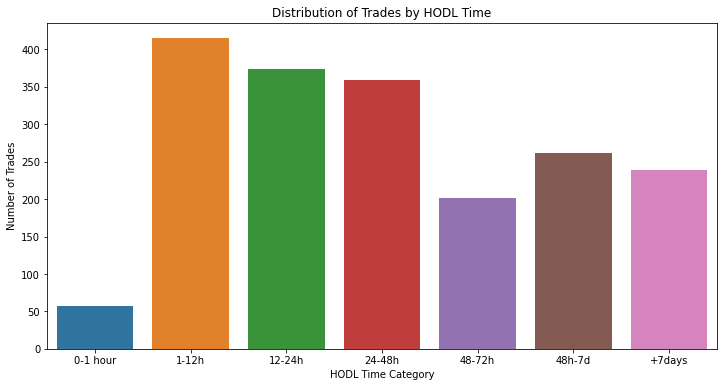

2.99% of NFTs are kept less than or equal to 0-1 hour
24.75% of NFTs are kept less than or equal to 1-12h
44.36% of NFTs are kept less than or equal to 12-24h
63.19% of NFTs are kept less than or equal to 24-48h
73.78% of NFTs are kept less than or equal to 48-72h
87.47% of NFTs are kept less than or equal to 48h-7d
100.00% of NFTs are kept less than or equal to +7days


<ipython-input-10-7c21925016f1>:52: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for category, percentage in cumulative_percentages.iteritems():


In [10]:
# Convert hodl_time from minutes to hours
trades_30d['hodl_time_hours'] = trades_30d['hodl_time'] / 60

# Defining a function to set the time hold in the right format

def minutes_to_dhms(minutes):
    '''Convert minutes into days, hours, and minutes.'''
    days = minutes // (24 * 60)
    minutes %= (24 * 60)
    hours = minutes // 60
    minutes %= 60
    return days, hours, minutes


# Create hodl_category based on hodl_time_hours
conditions = [
    (trades_30d['hodl_time_hours'] <= 1),
    (trades_30d['hodl_time_hours'] > 1) & (trades_30d['hodl_time_hours'] <= 12),
    (trades_30d['hodl_time_hours'] > 12) & (trades_30d['hodl_time_hours'] <= 24),
    (trades_30d['hodl_time_hours'] > 24) & (trades_30d['hodl_time_hours'] <= 48),
    (trades_30d['hodl_time_hours'] > 48) & (trades_30d['hodl_time_hours'] <= 72),
    (trades_30d['hodl_time_hours'] > 72) & (trades_30d['hodl_time_hours'] <= 168),
    (trades_30d['hodl_time_hours'] > 168)
]
choices = ['0-1 hour', '1-12h', '12-24h', '24-48h', '48-72h', '48h-7d', '+7days']

trades_30d['hodl_category'] = np.select(conditions, choices, default='Unknown')


# Count the number of NFTs in each category
category_counts = trades_30d['hodl_category'].value_counts()

# Order the counts based on our defined order of categories
ordered_counts = category_counts.loc[choices]

# Calculate the cumulative sum of these counts
cumulative_counts = ordered_counts.cumsum()

# Convert the cumulative sum to percentages
total_nfts = len(trades_30d)
cumulative_percentages = (cumulative_counts / total_nfts) * 100

# Plotting
plt.figure(figsize=(12, 6))
sns.countplot(x='hodl_category', data=trades_30d, order=choices)
plt.title('Distribution of Trades by HODL Time')
plt.ylabel('Number of Trades')
plt.xlabel('HODL Time Category')
plt.show()

# Print the percentages for each category
for category, percentage in cumulative_percentages.iteritems():
    print(f"{percentage:.2f}% of NFTs are kept less than or equal to {category}")


This teaches us the a vast majority of NFT that were both bought and sold in the last 30 days were actually sold in in the next 7 days. Actually, the median hold time is under two days. Before continuing the analysis, we look at the best top 10% best trades in ROI, to see whether these were performed rather on short time period or have a similar distribution.

### 2.1.2 Top 10% trades (ROI)

In [11]:
# Selecting only the top 10 percent trades (looking at ROI)
roi_threshold = trades_30d['roi'].quantile(0.9)
top_ROI_30d = trades_30d[trades_30d['roi'] > roi_threshold]

In [54]:
# Count the number of NFTs in each category
category_counts = top_ROI_30d['hodl_category'].value_counts()

# Order the counts based on our defined order of categories
ordered_counts = category_counts.loc[choices]

# Calculate the cumulative sum of these counts
cumulative_counts = ordered_counts.cumsum()

# Convert the cumulative sum to percentages
total_nfts = len(top_ROI_30d)
cumulative_percentages = (cumulative_counts / total_nfts) * 100

# Print the percentages for each category
for category, percentage in cumulative_percentages.iteritems():
    print(f"{percentage:.2f}% of NFTs are kept less than or equal to {category}")
    
# Calculate and print the median hold time in days, hours, and minutes
median_hold_time = top_ROI_30d['hodl_time'].median()
days, hours, mins = minutes_to_dhms(median_hold_time)
print('')
print(f"The median hold time for NFTs is {days} days, {hours} hours, and {mins} minutes.")
print('')

0.52% of NFTs are kept less than or equal to 0-1 hour
20.94% of NFTs are kept less than or equal to 1-12h
69.63% of NFTs are kept less than or equal to 12-24h
89.01% of NFTs are kept less than or equal to 24-48h
91.62% of NFTs are kept less than or equal to 48-72h
94.24% of NFTs are kept less than or equal to 48h-7d
100.00% of NFTs are kept less than or equal to +7days

The median hold time for NFTs is 0.0 days, 16.0 hours, and 54.0 minutes.



<ipython-input-54-505d90c693ac>:15: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for category, percentage in cumulative_percentages.iteritems():


This analysis highlights the fact that the most profitable trades are actually usually very short term (less than 48h) with a median hold time of just above 17 hours. 

The idea is now to understand which of the collections have been bought and sold in the last 7 days, the enables us to understand which collections our traders focus on at the moment and collect additional data about for these specific projects.

## 1.2 Identifying most profitable collections in the last 7 days

In this section, we try to understand which collection our best traders are trading in the last 30 days. Of those collection, we then use performance measures to assess which colllections have been the most profitable for our top Solana NFT traders. 

### 1.2.1 NFT trades

We start by looking at key measures to assess most profitable collections traded by our top traders in the last 7 days. 

**Collecting key measures**

In [55]:
# Count of trades by collection 
num_sales = trades_7d.groupby('collection').size()

# Median profit for each collection
median_profit = trades_7d.groupby('collection')['profit'].median()

# Total profit for each collection
sum_profit = trades_7d.groupby('collection')['profit'].sum()

# Median ROI for each collection
median_roi = trades_7d.groupby('collection')['roi'].median()

# Filter out collections with more than 5 trades (we do not focus on collections that are barely traded)
collections_with_more_than_5_sales = num_sales[num_sales > 5].index

# Create a dataframe
df_collections = pd.DataFrame({
    'Number_of_Sales': num_sales,
    'Median_Profit': median_profit,
    'Median_Roi': median_roi
})

# Filter based on collections with more than 5 trades
df_collections = df_collections[df_collections.index.isin(collections_with_more_than_5_sales)]

**Most profitable collections collections**

We select collections that both have high median profit on trades as well as high median ROI

In [56]:
# Sort by descending median profit
best_profit = df_collections.sort_values(by='Median_Profit', ascending=False)
# Sort by descending median profit
best_roi = df_collections.sort_values(by='Median_Roi', ascending=False)


# Extract top 10 collection names from both rankings
top10_profit_collections = best_profit.index[:10].tolist()
top10_roi_collections = best_roi.index[:10].tolist()

# Find the intersection of the two lists
common_top10_collections = list(set(top10_profit_collections) & set(top10_roi_collections))

# Filter the original DataFrame using the intersection
best_collections = df_collections[df_collections.index.isin(common_top10_collections)]

best_collections

,Number_of_Sales,Median_Profit,Median_Roi
collection,,,
assetdash_vanta,30,3.949581,0.403237
clear_collectibles,62,0.658997,0.363598
dgs_gen1,31,0.423704,0.494658
downgrapes,40,0.282804,0.312957
helions,19,0.461968,0.212738
honeyland_generations_bees,16,0.355938,2.098316
magicticket,8,0.238044,0.162975
reavers,163,2.251257,0.276646
shredded_apes_gym_club,6,0.544727,0.175985


Table above gives us an idea of the collection traded this past week and that have been both profitable in terms of absolute profit and ROI for our traders of interets. One limitation of looking at these collections though, is that our traders have already realised profit on these collections. As such it is potentially already too late to focus on investing in these.

### 1.1.2  NFT purchases 

We therefore also have a look at collections that our traders are heavily investing in right now, and have not necessarily sold yet. Identyfing these collections will then be used to collect additional data about them.

In [57]:
n_purchasers = purchases_7d['acheteur'].nunique()
n_collections = purchases_7d['collection'].nunique()
n_purchases = len(purchases_7d)

print(f'There have been {n_purchasers} active top Solana traders purchasing NFTs in the last 7d, trading {n_collections} collections for a total of {n_purchases} purchases.')

There have been 33 active top Solana traders purchasing NFTs in the last 7d, trading 175 collections for a total of 1096 purchases.


In [58]:
sorted_purchases_7d.head(5)

,collection,num_purchases,unique_buyers,avg_price,min_price,max_price,median_price,volume
29,clear_collectibles,154,9,2.030858,1.585412,7.485204,1.832916,312.752139
115,reavers,18,4,8.837812,7.679160,12.471548,8.863448,159.080624
64,helions,61,1,2.419110,2.150056,2.785481,2.400159,147.565701
43,degenfatcats,12,1,6.675535,6.165240,7.031760,6.771819,80.106416
126,smb_barrel,6,1,11.168362,10.631564,11.705448,11.168128,67.010173


### 1.2.3 All sales

Next, looking at sales is interesting as it helps us identify which collections our traders are getting rid of. Most importantly, this data should be used to assess which collections have been overbought/oversold by our top traders in the last week.

In [59]:
n_sellers = sales_7d['vendeur'].nunique()
n_collections = sales_7d['collection'].nunique()
n_sales = len(sales_7d)

print(f'There have been {n_sellers} active top Solana traders selling NFTs in the last 7d, trading {n_collections} collections for a total of {n_sales} purchases.')

There have been 34 active top Solana traders selling NFTs in the last 7d, trading 114 collections for a total of 712 purchases.


In [60]:
sorted_sales_7d.head()

,collection,num_sales,avg_roi,avg_price,min_price,max_price,median_price,volume
76,reavers,146,0.301491,10.692314,7.450056,19.142808,10.376056,1561.077855
6,assetdash_vanta,29,0.430728,13.386467,11.493244,15.672761,13.621244,388.207547
22,clear_collectibles,70,0.574790,3.047603,1.840736,8.561448,3.102156,213.332225
47,helions,17,0.197051,2.631609,2.622764,2.633504,2.633504,44.737353
103,tomorrowland_winter,1,0.858807,44.618052,44.618052,44.618052,44.618052,44.618052


### 1.2.4 Purchased VS Sold collections

We hereby compare the amount of NFTs sold per collection by our top nft traders. We look at top ten most bought NFT collections (by volume). For each collection, we compare the number of NFT bought versus sold by top traders. 

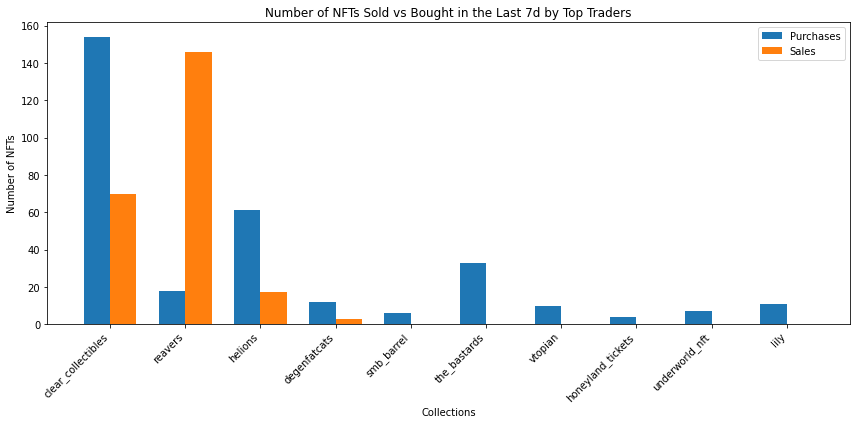

In [61]:
# Define a list of collections to keep
collections_to_keep_7d = sorted_purchases_7d['collection'].head(10).tolist()


# Filter the purchases_last24h DataFrame
filtered_purchases = purchases_7d[purchases_7d['collection'].isin(collections_to_keep_7d)]
filtered_sales = sales_7d[sales_7d['collection'].isin(collections_to_keep_7d)]


# Group and count purchases and sales
purchase_counts = filtered_purchases['collection'].value_counts()
sale_counts = filtered_sales['collection'].value_counts()

# Get positions for bar plot
bar_width = 0.35
index = np.arange(len(collections_to_keep_7d))

# Determine collections that have had either sales or purchases (or both) in the past 7d
valid_collections = [col for col in collections_to_keep_7d if col in purchase_counts or col in sale_counts]

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
index = np.arange(len(valid_collections))
bar1 = ax.bar(index, purchase_counts.reindex(valid_collections).fillna(0), bar_width, label='Purchases', align='center')
bar2 = ax.bar(index + bar_width, sale_counts.reindex(valid_collections).fillna(0), bar_width, label='Sales', align='center')

# Labeling and aesthetics
ax.set_xlabel('Collections')
ax.set_ylabel('Number of NFTs')
ax.set_title('Number of NFTs Sold vs Bought in the Last 7d by Top Traders')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(valid_collections, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

---

# PART 3: Data Collection and storage for target Collections

---

From part 2, we have identified the most invested in collections over the last 7 days. We now collect additional information on these highly traded collections. The idea here, is to collect data on interesting collection troughout the days, and store into into a DB. Each day, we will then look at highly traded collections (part 4), and the data collected in this section can the be used to better understand price movements. 

## 3.1 Key Statistics

**Adding today's stats for collections of interests to MongoDB**

In [20]:
# Connecting to the stats collection

collections_stats = db.collections_stats

# Requests setup
base_url = "https://api-mainnet.magiceden.dev/v2/collections/"
headers = {"accept": "application/json"}

# Collection to analyze
collections_to_keep = sorted_purchases_7d['collection'].head(20).tolist()

# The date
today_str = datetime.datetime.now().strftime("%Y-%m-%d")


for coll_name in collections_to_keep:
    stats_url = base_url + coll_name + "/stats"
    holders_url = base_url + coll_name + "/holder_stats"
    
    response_stats = requests.get(stats_url, headers=headers)
    response_holders = requests.get(holders_url, headers=headers)
    
    today_str = datetime.datetime.now().strftime("%Y-%m-%d")
    
    # Check if a document for this collection with today's date already exists
    existing_entry = collections_stats.find_one({"symbol": coll_name, "datetime": {"$regex": "^" + today_str}})    
    if existing_entry:
        print(f"Data for {coll_name} already exists for today. Skipping...")
        continue
    
    # Check if the request was successful before processing
    if response_stats.status_code == 200 and response_holders.status_code == 200:
        stats = response_stats.json()
        
        # Extracting totalSupply and uniqueHolders from holders_stats
        holder_data = response_holders.json()
        stats['totalSupply'] = holder_data['totalSupply']
        stats['uniqueHolders'] = holder_data['uniqueHolders']
        
        # Adding today's date and time to the stats
        stats['datetime'] = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        
        # Inserting the data into MongoDB
        collections_stats.insert_one(stats)
        print(f"Data for {coll_name} inserted successfully!")
    else:
        print(f"Failed to fetch data for {coll_name}. Status codes: {response_stats.status_code}, {response_holders.status_code}")

Data for clear_collectibles inserted successfully!
Data for reavers inserted successfully!
Data for helions inserted successfully!
Data for degenfatcats inserted successfully!
Data for smb_barrel inserted successfully!
Data for the_bastards inserted successfully!
Data for vtopian inserted successfully!
Data for honeyland_tickets inserted successfully!
Data for underworld_nft inserted successfully!
Data for lily inserted successfully!
Data for okay_bears inserted successfully!
Data for assetdash_vanta inserted successfully!
Data for smb_gen3 inserted successfully!
Data for p2_farmers_gs inserted successfully!
Data for morts inserted successfully!
Data for gates_of_brohalla inserted successfully!
Data for maleficus inserted successfully!
Data for tomorrowland_winter inserted successfully!
Data for meegos inserted successfully!
Data for honeyland_land inserted successfully!


**Fetching historical stats of collections from mongoDB**

In [21]:
# Fetch all documents from the collection
data = list(collections_stats.find({}))

# Convert the list of dictionaries into a DataFrame
historical_stats = pd.DataFrame(data)

# Display the first few rows of the DataFrame

historical_stats.drop(columns=['_id'], inplace=True)

historical_stats['floorPrice'] = historical_stats['floorPrice'] / (10**9)
historical_stats['avgPrice24hr'] = historical_stats['avgPrice24hr'] / (10**9)
historical_stats['volumeAll'] = historical_stats['volumeAll'] / (10**9)

## 3.2 Listings

**Current listings for collections of interests**

In [22]:
all_data = []

base_url = "https://api-mainnet.magiceden.dev/v2/collections/"


for coll_name in collections_to_keep:
    url = base_url + coll_name + "/listings"
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        listings = response.json()
        
        for item in listings:
            # Extracting only the required info
            entry = {
                'seller': item.get('seller', None),
                'tokenMint': item.get('tokenMint', None),
                'absolute_rarity': item.get('rarity', {}).get('moonrank', {}).get('absolute_rarity', None),
                'price': item.get('price', None),
                'pdaAddress': item.get('pdaAddress', None),
                'collection': coll_name
            }
            all_data.append(entry)
            
    print(f"Data for {coll_name} inserted successfully!")

# Convert list of dictionaries to DataFrame
listings = pd.DataFrame(all_data)

Data for clear_collectibles inserted successfully!
Data for reavers inserted successfully!
Data for helions inserted successfully!
Data for degenfatcats inserted successfully!
Data for smb_barrel inserted successfully!
Data for the_bastards inserted successfully!
Data for vtopian inserted successfully!
Data for honeyland_tickets inserted successfully!
Data for underworld_nft inserted successfully!
Data for lily inserted successfully!
Data for okay_bears inserted successfully!
Data for assetdash_vanta inserted successfully!
Data for smb_gen3 inserted successfully!
Data for p2_farmers_gs inserted successfully!
Data for morts inserted successfully!
Data for gates_of_brohalla inserted successfully!
Data for maleficus inserted successfully!
Data for tomorrowland_winter inserted successfully!
Data for meegos inserted successfully!
Data for honeyland_land inserted successfully!


## 2.3 Top holders

**Adding today's TOP Holders for collections of interests**

In [23]:
# My top holders collection

topholders_db = db.holders_data


# Inserting the top holders data in MongoDB
for coll_name in collections_to_keep:
    holders_url = base_url + coll_name + "/holder_stats"
    response_holders = requests.get(holders_url, headers=headers)

    # Flag to determine if new data was inserted for this collection
    new_data_inserted = False

    if response_holders.status_code == 200:
        holder_data = response_holders.json()

        # Loop through the topHolders
        for holder in holder_data['topHolders']:
            # Check for the existence of expected keys
            if all(key in holder for key in ['owner', 'tokens', 'buy7d', 'sell7d']):
                owner = holder['owner']
                tokens = holder['tokens']
                buy7d = holder['buy7d']['count']
                sell7d = holder['sell7d']['count']

                # Check if data for this holder with today's date already exists
                existing_entry = topholders_db.find_one({"owner": owner, "date": today_str, "collection_name": coll_name})

                if not existing_entry:
                    entry = {
                        "collection_name": coll_name,
                        "owner": owner,
                        "tokens": tokens,
                        "buy7d": buy7d,
                        "sell7d": sell7d,
                        "date": today_str
                    }
                    topholders_db.insert_one(entry)
                    new_data_inserted = True
            else:
                print(f"Unexpected data format for collection {coll_name}.")

    if new_data_inserted:
        print(f"New data inserted for {coll_name}!")
    else:
        print(f"No new data for {coll_name} today.")



New data inserted for clear_collectibles!
New data inserted for reavers!
New data inserted for helions!
New data inserted for degenfatcats!
New data inserted for smb_barrel!
New data inserted for the_bastards!
New data inserted for vtopian!
New data inserted for honeyland_tickets!
New data inserted for underworld_nft!
New data inserted for lily!
New data inserted for okay_bears!
New data inserted for assetdash_vanta!
Unexpected data format for collection smb_gen3.
New data inserted for smb_gen3!
New data inserted for p2_farmers_gs!
New data inserted for morts!
New data inserted for gates_of_brohalla!
New data inserted for maleficus!
New data inserted for tomorrowland_winter!
New data inserted for meegos!
New data inserted for honeyland_land!


**Fetching Historical top holder's data**

In [24]:
holders_data_list = list(db.holders_data.find({}))  
holders_df= pd.DataFrame(holders_data_list)

---

## PART 4: Current Trades

---

This section helps us identify the collection(s) of interest for today. We look at currently highly overbought collections to assess what to buy. 

### 4.1  All purchases (last 24h)

In [65]:
n_traders = purchases_24h['acheteur'].nunique()
n_collections = purchases_24h['collection'].nunique()
n_purchases = len(purchases_24h)

print(f'There have been {n_traders} active top Solana traders purchasing NFTs today, trading {n_collections} collections for a total of {n_purchases} purchases.')


There have been 18 active top Solana traders purchasing NFTs today, trading 44 collections for a total of 205 purchases.


In [69]:
sorted_purchases_24h.head(10)

,collection,num_purchases,unique_buyers,avg_price,min_price,max_price,median_price,volume
6,clear_collectibles,20,5,2.565453,1.605556,6.843804,2.001707,51.309062
29,p2_farmers_gs,59,1,0.472487,0.438072,0.507126,0.471585,27.876727
17,gates_of_brohalla,2,2,11.257504,5.089560,17.425448,11.257504,22.515008
10,degenfatcats,2,1,6.688140,6.603480,6.772800,6.688140,13.376280
2,bored_ape_solana_club,1,1,11.488448,11.488448,11.488448,11.488448,11.488448
7,cranimus,44,3,0.234182,0.159758,0.594760,0.171400,10.303997
4,bullyz_crew,2,2,3.909300,3.904320,3.914280,3.909300,7.818600
8,crashfaces,2,2,3.700140,3.685200,3.715080,3.700140,7.400280
28,nekkro,2,1,3.321660,3.266880,3.376440,3.321660,6.643320
31,puffsterz,2,2,3.156324,3.155328,3.157320,3.156324,6.312648


### 4.2 All sales (last 24h)

In [68]:
sorted_sales_24h.head(5)

,collection,num_sales,avg_roi,avg_price,min_price,max_price,median_price,volume
5,clear_collectibles,53,0.666774,3.278470,1.840736,8.561448,3.177134,173.758911
0,assetdash_vanta,9,0.410558,13.706334,13.621244,13.813073,13.703123,123.357004
7,cranimus,57,0.649536,0.410392,0.319576,0.637244,0.404248,23.392343
9,cryptotitans,2,0.289921,6.513098,6.512084,6.514112,6.513098,13.026197
12,dopegrowerssociety,2,2.427473,5.827680,5.242316,6.413044,5.827680,11.655361


#### 4.3 Sales vs Purchases in collections of interest (24H)

In the graph below we look at trades on collection for which we have data in our historical db but also new collection that are not in the 7 days top traded. These are plotted in different colours for two main reasons. First, it allows us to identify newly trending collections. Additionally, it helps us identify whether we have additional information before selecting today's collection of interest.

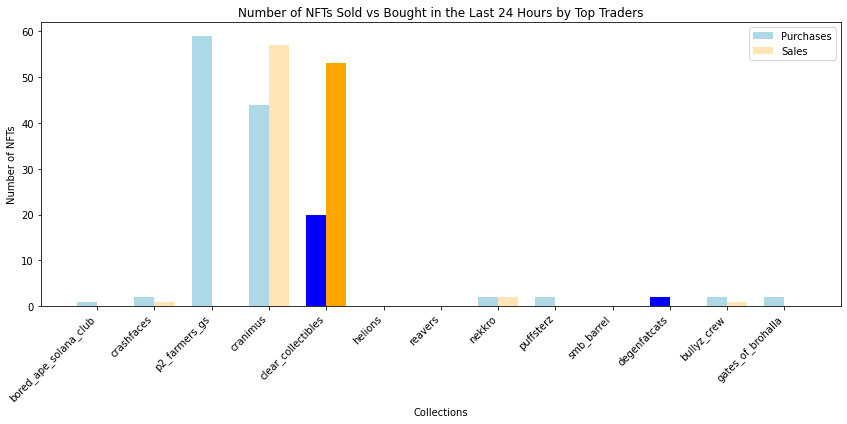

In [70]:
# Define a list of collections to keep
collections_to_keep_7d = sorted_purchases_7d['collection'].head(5).tolist()
collections_to_keep_24h = sorted_purchases_24h['collection'].head(10).tolist()


# Combine both lists while ensuring uniqueness
combined_collections_to_keep = list(set(collections_to_keep_7d + collections_to_keep_24h))

# Collections exclusive to the 24-hour list (not present in the 7-day list)
collections_only_in_24h = list(set(collections_to_keep_24h) - set(collections_to_keep_7d))

# Group and count purchases and sales
purchase_counts = purchases_24h['collection'].value_counts()
sale_counts = sales_24h['collection'].value_counts()

# Create colors list based on criteria
colors_purchases = ['blue' if col in collections_to_keep_7d else 'lightblue' for col in combined_collections_to_keep]
colors_sales = ['orange' if col in collections_to_keep_7d else 'moccasin' for col in combined_collections_to_keep]

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
index = np.arange(len(combined_collections_to_keep))

bar1 = ax.bar(index, 
              purchase_counts.reindex(combined_collections_to_keep).fillna(0), 
              bar_width, 
              color=colors_purchases, 
              label='Purchases', 
              align='center')

bar2 = ax.bar(index + bar_width, 
              sale_counts.reindex(combined_collections_to_keep).fillna(0), 
              bar_width, 
              color=colors_sales, 
              label='Sales', 
              align='center')

# Labeling and aesthetics
ax.set_xlabel('Collections')
ax.set_ylabel('Number of NFTs')
ax.set_title('Number of NFTs Sold vs Bought in the Last 24 Hours by Top Traders')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(combined_collections_to_keep, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()




--- 

# PART 5 : ANALYZING TODAY'S COLLECTION OF INTEREST

---

Part 4 has helped us identify which collection to trade today. In this section we dive deeper into this collection before taking any additional decisions. We look at the summary statistics of buy prices by our traders of interests. Next we look at very short term data : are they still buying or is it already sell time? 

We also hereby also look at historical data if available : are the collections whales accumulating or rather selling ? is the floor price moving up? etc.

Finally, we collect data from twitter : we look at the latest tweets made by the official account of the collection but also perform sentiment analysis on all recents tweets about it. This makes us aware of any important announcements and community feeling about the collection.



### 5.1 Collection identification

In [82]:
today_collection = 'clear_collectibles'

### 5.2 Top traders activity (last 6h)

#### 5.2.1 Purchases

In [83]:
collection_purchases_6h = purchases_6h[purchases_6h['collection'] == today_collection]
collection_purchases_6h.head()

,acheteur,nft,date_achat,prix_achat,collection
16,BiKcVb6t6YDZczYjWLjXKwdgAUecdQrp1EJXAfRmu3VR,7tgrYbnBjQyyEnrsA9RGpnbX8U7U4MLzqvSJFWjCGRFx,2023-09-27T19:39:49.000Z,5.827498,clear_collectibles
17,BiKcVb6t6YDZczYjWLjXKwdgAUecdQrp1EJXAfRmu3VR,Gr9iRgrNqSut1ruDGdnqWpeXiDHLiPBsr9Vz2NTNcuXA,2023-09-27T19:40:43.000Z,6.843804,clear_collectibles
18,BiKcVb6t6YDZczYjWLjXKwdgAUecdQrp1EJXAfRmu3VR,Dn4TsMQsQgVfp9EjUjjQSVhAYYQ21DBk1B1GWhvLmwM,2023-09-27T19:42:46.000Z,5.079198,clear_collectibles
41,AyfkJWUcVP5QionXtc9DTS6XVSgJZCund63xEAqN8744,9A6yWLLyW8qMSNfdHRgCYPYm7hvvr7D2sdK696vM4tY4,2023-09-28T03:38:49.000Z,3.727198,clear_collectibles
45,5GWUdSev42nKXXs49tKwcoZyozSwDoYDJTLSegV5NzFC,7rTwSXhMr1VanGnaePEAURSiuP7JZGDRztAJEHEy3kJk,2023-09-27T19:07:39.000Z,2.075916,clear_collectibles


#### 5.2.2 Sales

In [84]:
collection_sales_6h = sales_6h[sales_6h['collection'] == today_collection]
collection_sales_6h.head()

,vendeur,acheteur,nft,date_achat,date_vente,prix_achat,prix_vente,profit,roi,collection
1,F61wgdK7SgQEgZp7XJMtiUiqYuvcJ5P4PMCrzfpen3PX,6zR8YqvScoxY6Xe14pimoHUuanoWon75fctDS1Bs1MCN,9mkzmm7JuGmtW8XTtGYzoQdwtPRPZk4vju7qXiESeU8x,2023-09-27T19:01:34.000Z,2023-09-28T15:34:15.000Z,2.193506,5.334327,3.140821,1.431872,clear_collectibles
2,HU5QwHHn4FhgtKYuCCMTsvKqkHspPRRYXvyjMtQ4kaBq,Hn5Vi2Ler5nJPN1XZfA6bq9iGkUQU9brfjtVRvVzUuCU,HoPeo9bSnMcUFcU4eHUtAD9wvF95Yc2Yp72CKpo1YbiF,2023-09-27T03:41:13.000Z,2023-09-28T14:03:38.000Z,1.606448,4.278056,2.671609,1.663054,clear_collectibles
5,4qf49iU65pFYWTx3hCA7vikRRv5L3pg6im49yHXjLoQN,ahbDRH6pRRJZM6M2rfPD2SMfkJfQYueCfHd8UNurTcA,HpWCSuWtj8h62gdeLGbvWZW79Q13jigtsHX8DdNTV8kV,2023-09-25T17:13:28.000Z,2023-09-28T07:53:30.000Z,2.247104,4.281448,2.034343,0.905318,clear_collectibles
6,4qf49iU65pFYWTx3hCA7vikRRv5L3pg6im49yHXjLoQN,GrFAA1F6eA2wz4B3NQ2p2g4m2aLkzQCGDWi8dsLxruhJ,2BrDy9jiYfC3HU6NHvNJbUwuYduXi2bmhjkATbkPcotT,2023-09-25T17:13:11.000Z,2023-09-28T06:34:22.000Z,2.247104,4.281448,2.034343,0.905318,clear_collectibles
7,5GWUdSev42nKXXs49tKwcoZyozSwDoYDJTLSegV5NzFC,G7WZo5eJPwbJWsWDp5YVpt3BJwcBnx3m13tLj82daW37,BdFn9LKWDpt9dyFscC3YJXqntAvwd9YQz178q5vShHjU,2023-09-25T17:31:58.000Z,2023-09-28T14:38:13.000Z,1.625446,3.604586,1.979140,1.217598,clear_collectibles


#### 5.2.1 Purchases vs Sales

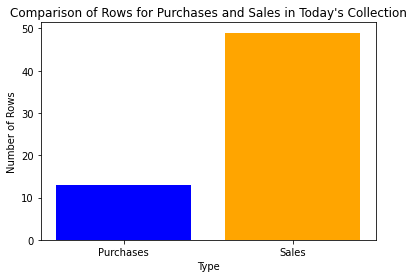

In [86]:
# Get the number of rows for each filtered dataframe
num_purchases = len(collection_purchases_6h)
num_sales = len(collection_sales_6h)

# Bar plot
labels = ['Purchases', 'Sales']
values = [num_purchases, num_sales]

plt.bar(labels, values, color=['blue', 'orange'])
plt.xlabel('Type')
plt.ylabel('Number of Rows')
plt.title('Comparison of Rows for Purchases and Sales in Today\'s Collection')
plt.show()



### 5.3 Top traders activity (1h)

In [87]:
collection_purchases_1h = purchases_1h[purchases_1h['collection'] == today_collection]
collection_purchases_1h.head()

,acheteur,nft,date_achat,prix_achat,collection
27,AyfkJWUcVP5QionXtc9DTS6XVSgJZCund63xEAqN8744,9A6yWLLyW8qMSNfdHRgCYPYm7hvvr7D2sdK696vM4tY4,2023-09-28T03:38:49.000Z,3.727198,clear_collectibles


In [88]:
collection_sales_1h = sales_1h[sales_1h['collection'] == today_collection]
collection_sales_1h.head()

,vendeur,acheteur,nft,date_achat,date_vente,prix_achat,prix_vente,profit,roi,collection
1,F61wgdK7SgQEgZp7XJMtiUiqYuvcJ5P4PMCrzfpen3PX,6zR8YqvScoxY6Xe14pimoHUuanoWon75fctDS1Bs1MCN,9mkzmm7JuGmtW8XTtGYzoQdwtPRPZk4vju7qXiESeU8x,2023-09-27T19:01:34.000Z,2023-09-28T15:34:15.000Z,2.193506,5.334327,3.140821,1.431872,clear_collectibles
2,HU5QwHHn4FhgtKYuCCMTsvKqkHspPRRYXvyjMtQ4kaBq,Hn5Vi2Ler5nJPN1XZfA6bq9iGkUQU9brfjtVRvVzUuCU,HoPeo9bSnMcUFcU4eHUtAD9wvF95Yc2Yp72CKpo1YbiF,2023-09-27T03:41:13.000Z,2023-09-28T14:03:38.000Z,1.606448,4.278056,2.671609,1.663054,clear_collectibles
4,4qf49iU65pFYWTx3hCA7vikRRv5L3pg6im49yHXjLoQN,GrFAA1F6eA2wz4B3NQ2p2g4m2aLkzQCGDWi8dsLxruhJ,2BrDy9jiYfC3HU6NHvNJbUwuYduXi2bmhjkATbkPcotT,2023-09-25T17:13:11.000Z,2023-09-28T06:34:22.000Z,2.247104,4.281448,2.034343,0.905318,clear_collectibles
5,4qf49iU65pFYWTx3hCA7vikRRv5L3pg6im49yHXjLoQN,ahbDRH6pRRJZM6M2rfPD2SMfkJfQYueCfHd8UNurTcA,HpWCSuWtj8h62gdeLGbvWZW79Q13jigtsHX8DdNTV8kV,2023-09-25T17:13:28.000Z,2023-09-28T07:53:30.000Z,2.247104,4.281448,2.034343,0.905318,clear_collectibles
6,5GWUdSev42nKXXs49tKwcoZyozSwDoYDJTLSegV5NzFC,G7WZo5eJPwbJWsWDp5YVpt3BJwcBnx3m13tLj82daW37,BdFn9LKWDpt9dyFscC3YJXqntAvwd9YQz178q5vShHjU,2023-09-25T17:31:58.000Z,2023-09-28T14:38:13.000Z,1.625446,3.604586,1.979140,1.217598,clear_collectibles


### 5.4 Historical available data : Magic Eden (from point 2)

#### 5.4.1 Collection Stats

<ipython-input-89-c5a08def87b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collection_stats.loc[:, 'datetime'] = pd.to_datetime(collection_stats['datetime'])
<ipython-input-89-c5a08def87b4>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  collection_stats.loc[:, 'datetime'] = pd.to_datetime(collection_stats['datetime'])


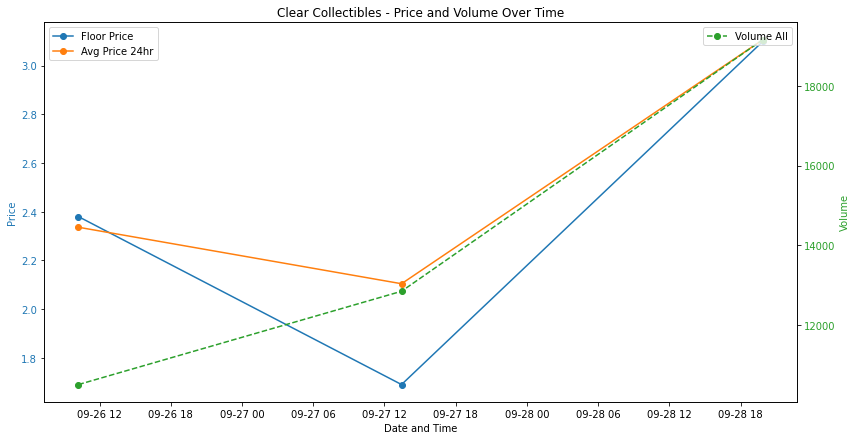

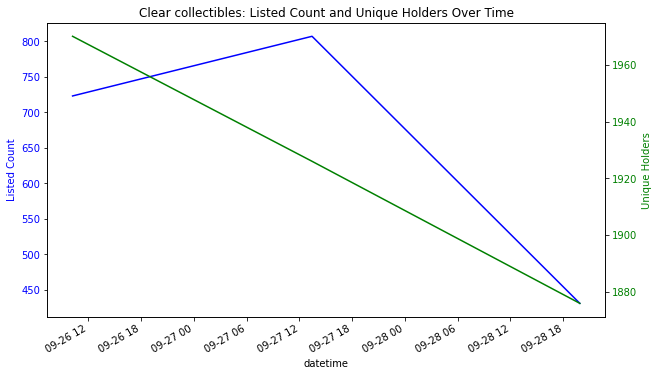

In [89]:
collection_stats = historical_stats[historical_stats['symbol'] == today_collection]
collection_stats.loc[:, 'datetime'] = pd.to_datetime(collection_stats['datetime'])
collection_stats = collection_stats.set_index('datetime')

# Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# First axis: floorPrice and avgPrice24hr
ax1.set_xlabel('Date and Time')
ax1.set_ylabel('Price', color='tab:blue')
ax1.plot(collection_stats.index, collection_stats['floorPrice'], color='tab:blue', marker='o', label='Floor Price')
ax1.plot(collection_stats.index, collection_stats['avgPrice24hr'], color='tab:orange', marker='o', label='Avg Price 24hr')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Create a second y-axis to represent volumeAll
ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='tab:green')
ax2.plot(collection_stats.index, collection_stats['volumeAll'], color='tab:green', marker='o', linestyle='dashed', label='Volume All')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.title('Clear Collectibles - Price and Volume Over Time')
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.show()


# Create a new figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot listedCount on the primary y-axis
collection_stats['listedCount'].plot(ax=ax1, label='Listed Count', color='b')
ax1.set_ylabel('Listed Count', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis for uniqueHolders
ax2 = ax1.twinx()
collection_stats['uniqueHolders'].plot(ax=ax2, label='Unique Holders', color='g')
ax2.set_ylabel('Unique Holders', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Set the title and x-axis label
plt.title('Clear collectibles: Listed Count and Unique Holders Over Time')
plt.xlabel('Datetime')

plt.show()

#### 5.4.2 Top collection holders

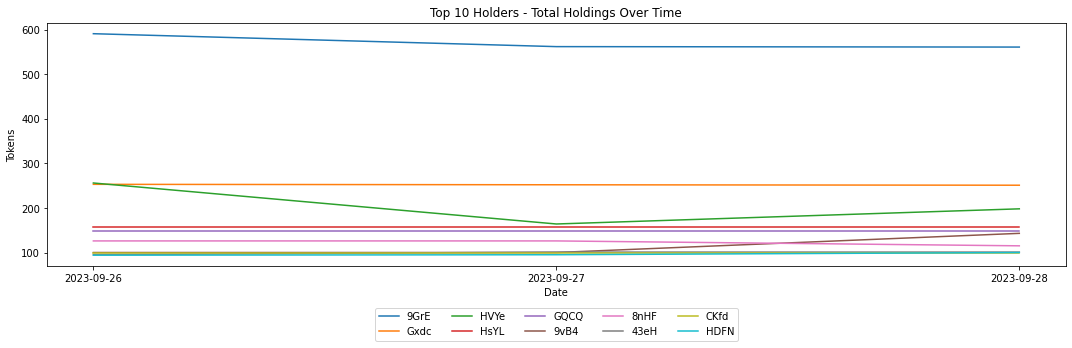

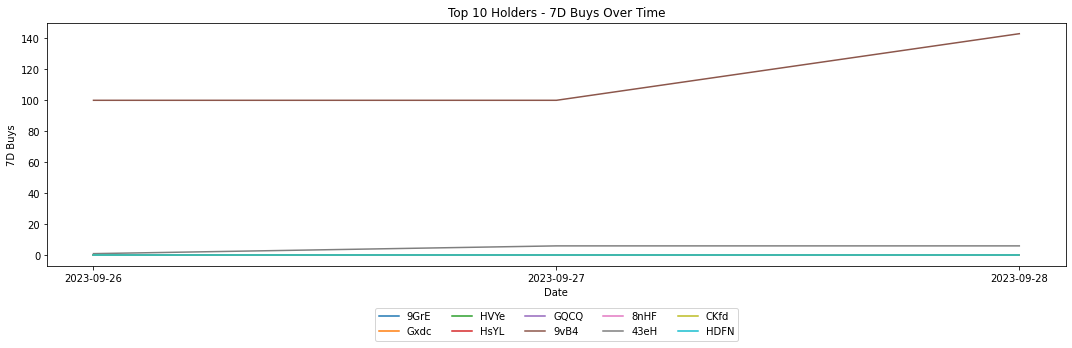

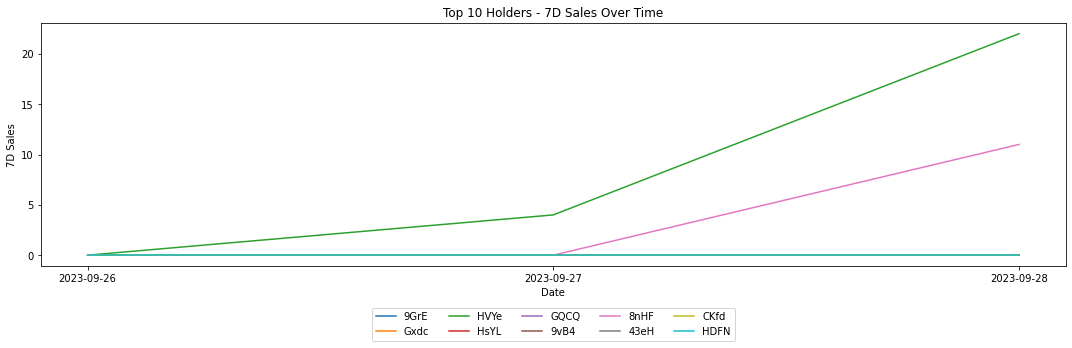

In [90]:
# Filter out 'downgrapes' collection
collection_holders = holders_df[holders_df['collection_name'] == today_collection]

# Identify the top 10 holders based on the latest entry
latest_date = collection_holders['date'].max()
top_holders = collection_holders[collection_holders['date'] == latest_date].nlargest(10, 'tokens')['owner'].tolist()

# Filter the DataFrame for these top holders
top_holders_df = collection_holders[collection_holders['owner'].isin(top_holders)]

# Plot the graphs
plt.figure(figsize=(15, 5))
for holder in top_holders:
    holder_data = top_holders_df[top_holders_df['owner'] == holder].sort_values(by='date')
    plt.plot(holder_data['date'], holder_data['tokens'], label=holder[:4])
plt.title('Top 10 Holders - Total Holdings Over Time')
plt.xlabel('Date')
plt.ylabel('Tokens')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)  # Adjust these values as needed
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
for holder in top_holders:
    holder_data = top_holders_df[top_holders_df['owner'] == holder].sort_values(by='date')
    plt.plot(holder_data['date'], holder_data['buy7d'], label=holder[:4])
plt.title('Top 10 Holders - 7D Buys Over Time')
plt.xlabel('Date')
plt.ylabel('7D Buys')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)  # Adjust these values as needed
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
for holder in top_holders:
    holder_data = top_holders_df[top_holders_df['owner'] == holder].sort_values(by='date')
    plt.plot(holder_data['date'], holder_data['sell7d'], label=holder[:4])
plt.title('Top 10 Holders - 7D Sales Over Time')
plt.xlabel('Date')
plt.ylabel('7D Sales')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)  # Adjust these values as needed
plt.tight_layout()
plt.show()

### 5.5 Twitter data (from point 2)

#### 5.5.1 Collecting the data (all tweets + official tweets)

In this section, we collect all tweets from the last 24 hours for the collections of interests. Next we also collect the Tweet's (official announcements) made on the project's founder to learn about any bullish updates.

In [117]:
# Twitter handles 

twitter_names = ["clearcollectnft","cranimus_MT
                   
twitter_handles = ["@clearcollectnft","@cranimus_MT"]


# Search Urls 

search_urls = [f"https://twitter.com/search?f=top&q={handle}%20lang%3Aen%20since%3A2023-09-28%20-filter%3Areplies&src=typed_query" for handle in twitter_names]



def fetch_from_api(actor_url, params):
    data = json.dumps(params).encode('utf-8')
    request = urllib.request.Request(actor_url, data=data, headers=headers)

    # Execute the request and get the response
    with urllib.request.urlopen(request) as response:
        response_body = json.loads(response.read().decode('utf-8'))
        run_id = response_body['data']['id']
        dataset_id = response_body['data']['defaultDatasetId']

    # Poll the actor's status
    while True:
        status_url = f"{BASE_URL}/actor-runs/{run_id}?token={API_TOKEN}"
        with urllib.request.urlopen(status_url) as response:
            run_data = json.load(response)
            if run_data['data']['status'] in ['SUCCEEDED', 'FAILED', 'TIMED-OUT', 'ABORTED']:
                break
        time.sleep(10)

    # Fetch the dataset data once the actor has finished
    dataset_url = f"{BASE_URL}/datasets/{dataset_id}/items?token={API_TOKEN}"
    with urllib.request.urlopen(dataset_url) as response:
        return json.load(response)
    
    
# Extractor
def tweet_flash_extractor(tweet):
    return {
        'tweet_id': tweet.get('tweet_id', None),
        'url': tweet.get('url', None),
        'text': tweet.get('text', None),
        'username': tweet.get('username', None),
        'likes': tweet.get('likes', 0),
        'mentions': tweet.get('tweet_mentions', [])
    }



# Parameters to get all tweets mentioning collections
                 
tweet_flash_params = {
    "filter:blue_verified": False,
    "filter:has_engagement": False,
    "filter:images": False,
    "filter:media": False,
    "filter:nativeretweets": False,
    "filter:quote": False,
    "filter:replies": False,
    "filter:retweets": False,
    "filter:safe": False,
    "filter:twimg": False,
    "filter:verified": False,
    "filter:videos": False,
    "language": "en",
    "max_tweets": 500,
    "newer_than": "2023-09-28",
    "only_tweets": True,
    "search_urls": search_urls,
    "use_experimental_scraper": False,
    "user_info": "user info and replying info"
}

# Parameters to collect official tweets of collections
                 
official_tweets_params = {
    "filter:blue_verified": False,
    "filter:has_engagement": False,
    "filter:images": False,
    "filter:media": False,
    "filter:nativeretweets": False,
    "filter:quote": False,
    "filter:replies": False,
    "filter:retweets": False,
    "filter:safe": False,
    "filter:twimg": False,
    "filter:verified": False,
    "filter:videos": False,
    "from_user": twitter_handles,
    "language": "en",
    "max_tweets": 10,
    "newer_than": "2023-09-28",
    "only_tweets": True,
    "use_experimental_scraper": False,
    "user_info": "user info and replying info"
}                 
                 
                 
                 
                 
# Fetching the data
tweets_df = convert_to_dataframe(fetch_from_api(f"{BASE_URL}/acts/shanes~tweet-flash/runs?token={API_TOKEN}", tweet_flash_params), tweet_flash_extractor)
official_tweets_df = convert_to_dataframe(fetch_from_api(f"{BASE_URL}/acts/shanes~tweet-flash/runs?token={API_TOKEN}", official_tweets_params), tweet_flash_extractor)


#### 5.5.2 Official announcements

In [130]:
for index, row in official_tweets_df.iterrows():
    print(row['text'])
    print('-'*80)  


3 days in and Clear Collectibles is shaking the @solana NFT market 🔥

Come check out what all the excitement is about!
--------------------------------------------------------------------------------


#### 5.5.3 Sentiment analysis

In [122]:
# load model and tokenizer
roberta = "cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)
labels = ['Negative', 'Neutral', 'Positive']

In [124]:
score_pos_list = []
score_neut_list = []
score_neg_list = []
tweets_sentiment = []


for tweet in tweets_df['text']:
    
    tweet_words = []

    for word in tweet.split(' '):
        if word.startswith('@') and len(word) > 1:
            word = '@user'

        elif word.startswith('http'):
            word = "http"
        tweet_words.append(word)

    tweet_proc = " ".join(tweet_words)

    # sentiment analysis
    encoded_tweet = tokenizer(tweet_proc, return_tensors='pt')
    # output = model(encoded_tweet['input_ids'], encoded_tweet['attention_mask'])
    output = model(**encoded_tweet)

    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    
    score_neg_list.append(scores[0])
    score_neut_list.append(scores[1])
    score_pos_list.append(scores[2])
    tweets_sentiment.append(labels[scores.argmax()])
    
tweets_df['score_pos'] = score_pos_list
tweets_df['score_neut'] = score_neut_list
tweets_df['score_neg'] = score_neg_list
tweets_df['sentiment_roberta'] = tweets_sentiment

Analysis for ClearCollectNFT:



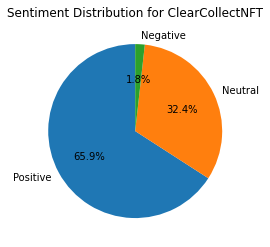


Top 5 Positive tweets for ClearCollectNFT:

- 1/x

It's time to jump into the clearverse

@ClearCollectNFT is a project I've been a part of for the last 3-4 months, working with @T_H_Crypto and the rest of his team to pivot from @NomadsNFT_ into something completely new. (Likes: 2312)


- ☀️ Hello #solana & @MagicEden community,

It's time to amazing #GIVEAWAY!

🎁 #NFT @ClearCollectNFT #975

✅ Follow @_Curvata & @ClearCollectNFT 
✅ ❤️ & RT this post
✅ Tag 3 friends

72h⏳ (Likes: 496)


- Congrats to @ClearCollectNFT for the quick mint out, easily the best art in pfps I have seen. I am super happy to buy 2 of the best 1/1s in the lot.

Presenting The King & The Queen (for me & the missus)

Thanks to @T_H_Crypto for graciously selling the king back to me at cost 😍 (Likes: 306)


- Decided to get 50 today. Very nice community, maybe gotta invite my friends. 

@ClearCollectNFT (Likes: 281)


- My @ClearCollectNFT moon bag looks cute.

These are meant to moon or to 0. 

They won't be leavi

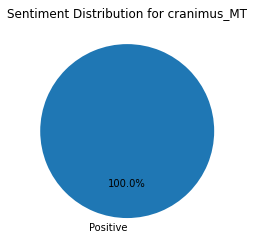


Top 5 Positive tweets for cranimus_MT:

- Update on my last two mints this week. 
@ClearCollectNFT (2 MP Public)
@cranimus_MT (0.04)

Benefits of being a @BroHallaNFT holder? You get the best alpha 😎
#Brolpha (Likes: 33)


Top 5 Negative tweets for cranimus_MT:





In [158]:
twitter_names = ['ClearCollectNFT', 'cranimus_MT']

for name in twitter_names:
    print("="*50)  # Separator
    print(f"Analysis for {name}:\n")
    
    # Filter tweets based on mentions column
    filtered_tweets = tweets_df[tweets_df['mentions'].apply(lambda x: name in x)]
    
    # Pie chart of sentiments
    sentiment_counts = filtered_tweets['sentiment_roberta'].value_counts()
    sentiment_counts.plot.pie(autopct='%1.1f%%', startangle=90)
    plt.title(f'Sentiment Distribution for {name}')
    plt.ylabel('')  # Removing the 'sentiment_roberta' ylabel
    plt.show()

    # Top 5 positive tweets with most likes
    top_positive = filtered_tweets[filtered_tweets['sentiment_roberta'] == 'Positive'].nlargest(5, 'likes')
    print(f"\nTop 5 Positive tweets for {name}:")
    for index, row in top_positive.iterrows():
        print()
        print(f"- {row['text']} (Likes: {row['likes']})")
        print()
    
    # Top 5 negative tweets with most likes
    top_negative = filtered_tweets[filtered_tweets['sentiment_roberta'] == 'Negative'].nlargest(5, 'likes')
    print(f"\nTop 5 Negative tweets for {name}:")
    for index, row in top_negative.iterrows():
        print()
        print(f"- {row['text']} (Likes: {row['likes']})")
        print()
    
    print("\n\n")

print("="*50)  # Final separator

